CoNLL-2003 dataset task demonstrates the labeling of tokens for named entity recognition (NER), part-of-speech (POS) tagging, and chunking. Each component of the JSON object corresponds to a different layer of annotation for the sentence:

1. **Tokens**: These are the individual words or punctuation marks from the text. In this case, the sentence "EU rejects German call to boycott British lamb." is split into tokens:
   - "EU"
   - "rejects"
   - "German"
   - "call"
   - "to"
   - "boycott"
   - "British"
   - "lamb"
   - "."

2. **POS Tags**: This array contains the POS tags corresponding to each token. The tags are encoded as numbers, each representing a specific part of speech (like noun, verb, adjective). These numbers usually correspond to a tagging scheme such as the Penn Treebank POS tags:
   - "EU" is tagged as 22, which represents a proper noun.
   - "rejects" is tagged as 42, indicating a verb in present tense.
   - And so forth.

3. **Chunk Tags**: This array indicates phrase chunk boundaries and types (like NP for noun phrase, VP for verb phrase). Each number again corresponds to a specific type of phrase or boundary in a predefined scheme:
   - "EU" is part of a noun phrase, hence 11.
   - "rejects" begins a verb phrase, indicated by 21.
   - The chunk tags help in parsing the sentence into linguistically meaningful phrases.

4. **NER Tags**: These tags are used for named entity recognition. They identify whether each token is part of a named entity (like a person, location, organization) and the type of entity:
   - "EU" is tagged as 3, denoting an organization.
   - "German" and "British" are tagged as 7, indicating nationality or ethnicity.
   - Other tokens are tagged as 0, meaning they are not recognized as part of any named entity.

 Homework: 
Load a NER dataset (e.g. CoNLL-2003) using the script provided below.
   - Create a custom nn.Module class that takes Glove word embeddings as input, passes them through a linear layer, and outputs NER tags
   - Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
   - Analyze the model's predictions and visualize the confusion matrix to identify common errors
2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 
   - 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 
   - 

In [1]:
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import GloVe, build_vocab_from_iterator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Load and preprocess CoNLL-2003 dataset
conll2003 = load_dataset("conll2003")
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print("dataset: \n")
print(conll2003)
print("\n====\n")
print("dataset tokens example:\n")
print(conll2003["train"]["tokens"][0])

"""
From type:
dataset = [{"tokens": ["EU", "rejects", "German", "call"]},
           {"tokens": ["British", "lamb", "."]}]
Provides only internal tokens:
                    ["EU", "rejects", "German", "call"],
                    ["British", "lamb", "."]

"""
def yield_tokens(data_iter):
    for item in data_iter:
        yield item["tokens"]

# Initial vocab alphabetically sorted from train tokens
vocab = build_vocab_from_iterator(yield_tokens(conll2003["train"]))

# Check current indices explicitly
pad_index = vocab.stoi["<pad>"]
unk_index = vocab.stoi["<unk>"]
print("<pad> index explicitly:", pad_index)
print("<unk> index explicitly:", unk_index)

# Labels dictionary
label_list = conll2003["train"].features["ner_tags"].feature.names
label2id = {label: i for i, label in enumerate(label_list)}


def vocab_lookup(token):
    return vocab.stoi.get(token, vocab.stoi["<unk>"])


test_tokens = ["EU", "rejects", "memes", "."]
test_indices = [vocab_lookup(tok) for tok in test_tokens]

print(f"Tokens explicitly: {test_tokens}")
print(f"Converted indices explicitly: {test_indices}")





C:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dataset: 

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

====

dataset tokens example:

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


14041lines [00:01, 10278.38lines/s]

<pad> index explicitly: 1
<unk> index explicitly: 0
Tokens explicitly: ['EU', 'rejects', 'memes', '.']
Converted indices explicitly: [964, 22407, 0, 2]


In [2]:
# This function receives examples with two main keys:
# examples = {
#     "tokens": [["EU", "rejects", "German", "call"], ["British", "lamb", "."]],
#     "ner_tags": [[3, 0, 7, 0], [7, 0, 0]]
# }
#
# It converts tokens into numerical indices using vocabulary lookup,
# clearly handling unknown tokens by assigning them the "<unk>" index.
#
# For example, given the tokens ["EU", "rejects", "unicorns"]:
# - "EU" -> known word, converts to vocab index (e.g., 10)
# - "rejects" -> known word, converts to vocab index (e.g., 20)
# - "unicorns" -> unknown word, converts to <unk> index (e.g., 1)
# Then we have [10, 20, 1]

def tokenize_and_align_labels(examples):
    # Convert tokens into vocab indices and labels into tensors
    token_indices = [
        torch.tensor([vocab_lookup(tok) for tok in sentence])
        for sentence in examples["tokens"]
    ]

    # Example: tokens ["EU", "rejects", "."] -> indices [10, 20, 3]
    labels = [
        torch.tensor(label_sequence)
        for label_sequence in examples["ner_tags"]
    ]

    # Return data in clearly structured format:
    # {
    #   "input_ids": [tensor([10, 20, 3]), tensor([5, 6, 7]), ...],
    #   "labels": [tensor([3, 0, 0]), tensor([7, 0, 0]), ...]
    # }
    return {"input_ids": token_indices, "labels": labels}


# Applying this function to our dataset
tokenized_conll2003 = conll2003.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=conll2003["train"].column_names
)

# Let's explicitly check the first processed example to clearly see:
print("Tokenized first example clearly:")
print(tokenized_conll2003["train"][0])

# Sample output clearly showing structure:
# {
#   "input_ids": tensor([10, 20, 30, 40]),
#   "labels": tensor([3, 0, 7, 0])
# }
# (where numbers are hypothetical vocab indices for simplicity in understanding)


Tokenized first example clearly:
{'input_ids': [964, 22407, 236, 771, 7, 4586, 210, 7684, 2], 'labels': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [3]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Special token index used explicitly for padding
pad_index = vocab.stoi["<pad>"]


def pad_collate_fn(batch):
    # batch is a list of items [{"input_ids":..., "labels":...}, {"input_ids":..., "labels":...}, ...]

    # Step A. Collect input_ids from every example in batch:
    # Example before padding: [tensor([4, 5, 6]), tensor([7, 8])]
    input_ids = [torch.tensor(item["input_ids"]) for item in batch]

    # Step B. Collect labels from every example in batch:
    # Example before padding: [tensor([0, 1, 2]), tensor([1, 0])]
    labels = [torch.tensor(item["labels"]) for item in batch]

    # Step C. Explicitly Pad input token indices with pad_index.
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=pad_index)
    # Clearly explained result: tensor([[4,5,6],[7,8,pad_index]])

    # Step D. Explicitly pad labels with -100 (ignored index for loss calculation)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)
    # Clearly explained result: tensor([[0,1,2],[1,0,-100]])

    # Step E. Return the batch as a new dictionary explicitly
    return {"input_ids": input_ids_padded, "labels": labels_padded}


# Create DataLoaders that explicitly applies padding.
train_loader = DataLoader(
    tokenized_conll2003["train"],  # Clearly reference tokenized dataset
    batch_size=32,  # Batch size
    shuffle=True,  # Shuffle data each epoch explicitly
    collate_fn=pad_collate_fn  # Explicitly padding function to be applied
)

test_loader = DataLoader(
    tokenized_conll2003["test"],
    batch_size=32,
    collate_fn=pad_collate_fn
)

batch_sample = next(iter(train_loader))

print(batch_sample["input_ids"].shape)
# input shape: [batch_size, max_seq_len]
# For example clearly : torch.Size([32, 55])

print(batch_sample["labels"].shape)
# batch shape: [batch_size, max_seq_len]
# For example clearly: torch.Size([32, 55])

print(batch_sample)
# Padded values <pad_index> for token indices 
# and -100 for labels at the end of shorter sequences.


torch.Size([32, 43])
torch.Size([32, 43])
{'input_ids': tensor([[ 1395,   228,   658,  ...,     1,     1,     1],
        [ 3268,    23,    16,  ...,     1,     1,     1],
        [   83,  1276,    99,  ...,     1,     1,     1],
        ...,
        [  125,    18, 14848,  ...,     1,     1,     1],
        [  231,    45,   344,  ...,   236,   270,     2],
        [ 9668,    97,     1,  ...,     1,     1,     1]]), 'labels': tensor([[   0,    7,    0,  ..., -100, -100, -100],
        [   3,    0,    0,  ..., -100, -100, -100],
        [   0,    0,    0,  ..., -100, -100, -100],
        ...,
        [   0,    0,    1,  ..., -100, -100, -100],
        [   0,    0,    0,  ...,    7,    0,    0],
        [   5,    0, -100,  ..., -100, -100, -100]])}


In [4]:
import torch.nn as nn
from torchtext.vocab import GloVe
import torch

embed_dim = 50
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)


class SimpleNERModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_tags):
        super(SimpleNERModel, self).__init__()

        # This layer converts numeric token indices into embeddings.
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_index)

        # Load pre-trained GloVe embeddings for semantic representations.
        glove = GloVe(name='6B', dim=embed_dim)

        # Create embedding matrix from GloVe for words existing in our vocab explicitly.
        embedding_matrix = torch.zeros(vocab_size, embed_dim)
        for idx, token in enumerate(vocab.itos):
            if token in glove.stoi:
                embedding_matrix[idx] = glove.vectors[glove.stoi[token]]  # Known token from GloVe
            else:
                embedding_matrix[idx] = torch.randn(embed_dim)  # Random vector for unknown token

        # Explicitly initializing the embedding layer with this embedding matrix
        self.embedding.weight.data.copy_(embedding_matrix)

        # A linear classifier layer predicting classes (NER tags clearly)
        # for each embedding vector (each token in input sentence).
        self.linear = nn.Linear(embed_dim, num_tags)

    def forward(self, x):
        # Given tokens [EU rejects unicorns], you have their numeric form [5, 20, 0]
        embedded = self.embedding(x)  # --> generates embedding vectors

        logits = self.linear(embedded)  # Linear layer predicts logits for each embedding clearly

        # (batch_size, seq_len, num_labels) explicitly returned
        return logits

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_tags = len(label_list)
model = SimpleNERModel(len(vocab), 50, num_tags).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


C:\Python312\Lib\site-packages\torchtext\vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim = torch.load(path_pt)


In [6]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.8521
Epoch [2/10], Loss: 0.5158
Epoch [3/10], Loss: 0.4177
Epoch [4/10], Loss: 0.3499
Epoch [5/10], Loss: 0.2992
Epoch [6/10], Loss: 0.2581
Epoch [7/10], Loss: 0.2251
Epoch [8/10], Loss: 0.2002
Epoch [9/10], Loss: 0.1790
Epoch [10/10], Loss: 0.1619


In [7]:
model.eval()
all_labels, all_predictions = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids)
        predictions = torch.argmax(outputs, dim=-1)

        labels_flat = labels[labels != -100].cpu().numpy()
        predictions_flat = predictions[labels != -100].cpu().numpy()

        all_labels.extend(labels_flat)
        all_predictions.extend(predictions_flat)

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=label_list))


Classification Report:
              precision    recall  f1-score   support

           O       0.93      0.99      0.96     38323
       B-PER       0.76      0.40      0.52      1617
       I-PER       0.45      0.13      0.21      1156
       B-ORG       0.73      0.50      0.59      1661
       I-ORG       0.66      0.44      0.53       835
       B-LOC       0.80      0.75      0.78      1668
       I-LOC       0.73      0.47      0.57       257
      B-MISC       0.72      0.63      0.67       702
      I-MISC       0.60      0.55      0.57       216

    accuracy                           0.91     46435
   macro avg       0.71      0.54      0.60     46435
weighted avg       0.89      0.91      0.89     46435



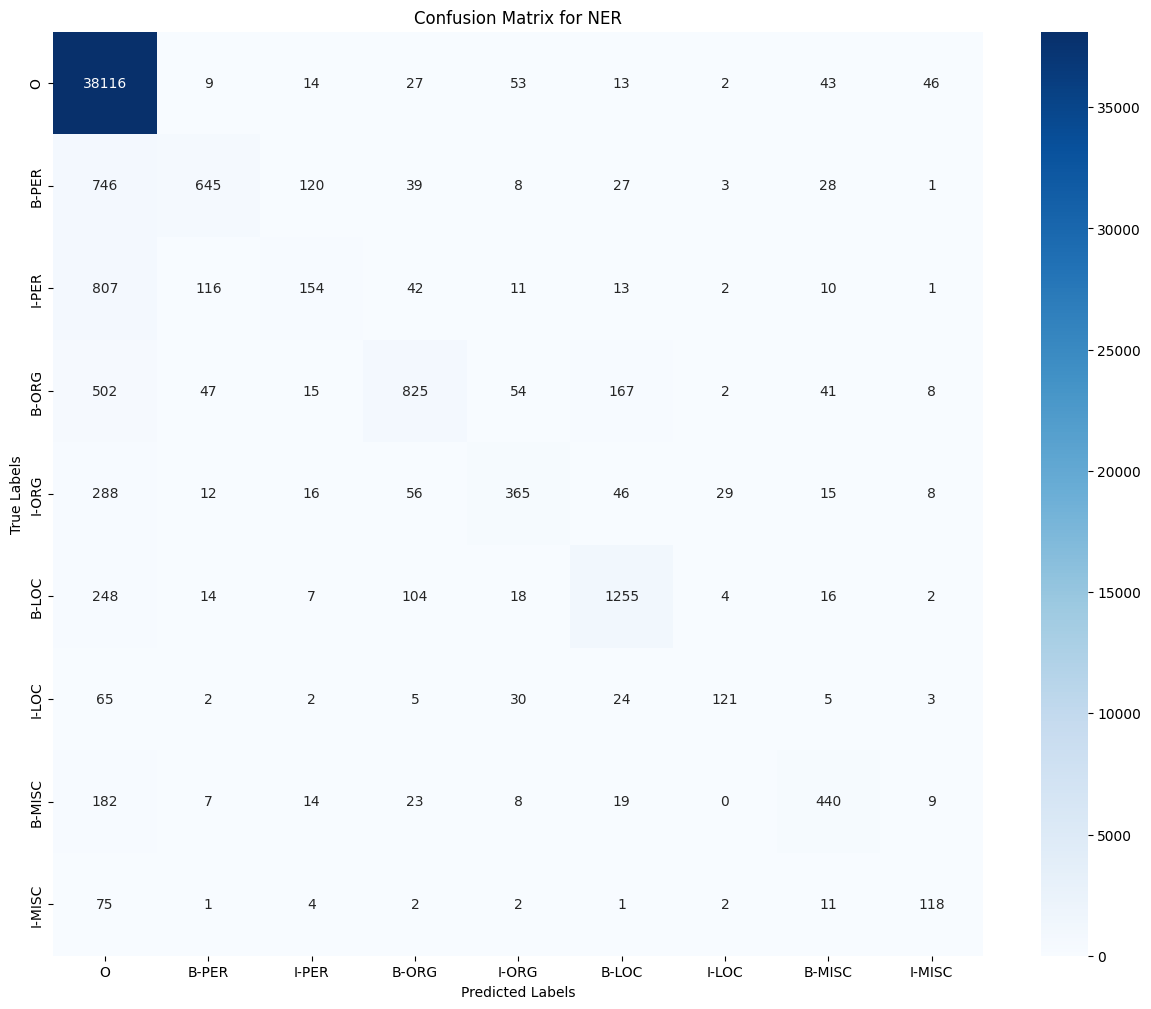

In [8]:
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for NER")
plt.show()


In [9]:
pad_idx = vocab.stoi["<pad>"]

class MLP_NER(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dims, num_tags, pad_idx):
        super().__init__()

        # GloVe embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        glove = GloVe(name='6B', dim=embed_dim)

        # Initialize embedding weights using GloVe embeddings explicitly
        embedding_matrix = torch.zeros(vocab_size, embed_dim)
        for i, token in enumerate(vocab.itos):
            if token in glove.stoi:
                embedding_matrix[i] = glove.vectors[glove.stoi[token]]
            else:
                embedding_matrix[i] = torch.randn(embed_dim)

        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings for efficiency

        layers = []
        input_dim = embed_dim

        # Build hidden layers explicitly
        for hidden_dim in hidden_dims:
            layers += [
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
            ]
            input_dim = hidden_dim

        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(input_dim, num_tags)

    def forward(self, x):
        x = self.embedding(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x


# Example initialization clearly defined:
model_mlp = MLP_NER(
    vocab_size=len(vocab.itos),
    embed_dim=50,
    hidden_dims=[128, 64],  # You will experiment here clearly
    num_tags=len(conll2003["train"].features["ner_tags"].feature.names),
    pad_idx=pad_idx
)

print("MLP NER Model architecture explicitly detailed:\n", model_mlp)


C:\Python312\Lib\site-packages\torchtext\vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim = torch.load(path_pt)


MLP NER Model architecture explicitly detailed:
 MLP_NER(
  (embedding): Embedding(23625, 50, padding_idx=1)
  (hidden_layers): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=9, bias=True)
)


In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)


# Explicit training loop
def train_model(model, data_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in data_loader:
            input_ids, labels = batch["input_ids"], batch["labels"]
            optimizer.zero_grad()
            predictions = model(input_ids)
            loss = criterion(predictions.view(-1, model.output_layer.out_features), labels.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(data_loader)
        print(f"Epoch {epoch + 1}/{epochs}: Loss explicitly={avg_loss:.4f}")


train_model(model_mlp, train_loader, optimizer, criterion, epochs=5)


Epoch 1/5: Loss explicitly=0.5699
Epoch 2/5: Loss explicitly=0.4138
Epoch 3/5: Loss explicitly=0.3729
Epoch 4/5: Loss explicitly=0.3471
Epoch 5/5: Loss explicitly=0.3279


In [11]:
model_mlp.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, labels = batch["input_ids"], batch["labels"]
        predictions = model_mlp(input_ids)

        preds = predictions.argmax(dim=-1)

        mask = labels != -100
        preds_flat = preds[mask].cpu().numpy()
        labels_flat = labels[mask].cpu().numpy()

        all_preds.extend(preds_flat)
        all_labels.extend(labels_flat)

target_names = conll2003["train"].features["ner_tags"].feature.names
print("\nExplicitly Clear Classification Report for MLP:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))



Explicitly Clear Classification Report for MLP:

              precision    recall  f1-score   support

           O       0.90      0.99      0.95     38323
       B-PER       0.52      0.29      0.37      1617
       I-PER       0.29      0.02      0.03      1156
       B-ORG       0.50      0.32      0.39      1661
       I-ORG       0.57      0.17      0.26       835
       B-LOC       0.82      0.57      0.67      1668
       I-LOC       0.68      0.30      0.42       257
      B-MISC       0.68      0.47      0.56       702
      I-MISC       0.71      0.41      0.52       216

    accuracy                           0.88     46435
   macro avg       0.63      0.39      0.46     46435
weighted avg       0.84      0.88      0.85     46435

